# Model interpretation (Estimators of the longitudinal displacements)

In this notebook we will analyse the predictions of the uniformity criterion NRDD of the longitudinal mode. The best score was achieved with a Keras dense neural network

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
import shap
from scipy.interpolate import griddata

In [3]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'
#base_dir = r'D:\FBr\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-parameters.ft')
ft_modes_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-modes.ft')
ft_nodes_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-nodes.ft')
ft_defs_path = os.path.join(base_dir, 'Scripts', str(fam) + '-coll-defs.ft')
df_params = pd.read_feather(ft_param_path)
df_modes = pd.read_feather(ft_modes_path)
df_nodes = pd.read_feather(ft_nodes_path)
df_defs = pd.read_feather(ft_defs_path)

In [4]:
lst_param = df_params.columns.to_list()

In [5]:
# Explanatory variables: all slot classes are considered, we add the 4 encoded columns to the selected dataset
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
X = df_params[lst_expl + lst_slot_class]

# Target variable is the frequency of the longitudinal mode
y = df_params[['long_disp_nrdd']]

num_expl = X.shape[1]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
idx_train = X_train.index
idx_test = X_test.index

In [7]:
# Apply the StandardScaler to the explanatory variables of the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[lst_expl])
X_train_scaled = pd.concat([pd.DataFrame(X_train_scaled, columns=lst_expl, index=idx_train), X_train[lst_slot_class]], axis=1)

In [8]:
# Apply the power transformer to the NRDD variable: the new variables will be named w to differentiate them from the actual values
transf = PowerTransformer()
w_train = pd.DataFrame(transf.fit_transform(y_train), index=idx_train)
w_test = pd.DataFrame(transf.transform(y_test), index=idx_test)

## KerasRegressor

The tuning of the neural network model gave us the following parameters for the definition:

In [9]:
nb_neurons = 25
init_mode = 'normal'
activation = 'softmax'

We define a pipeline containing 2 steps: the scaling of the variables and the regressor:

In [10]:
# Preprocessing
preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

# Define the Keras regressor
regressor = Sequential()
regressor.add(Dense(nb_neurons, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation, name='layer_0'))
regressor.add(Dense(1, kernel_initializer=init_mode, name='layer_1'))
regressor.compile(loss='mse', optimizer=Adam(learning_rate=0.043))

# Create the main pipeline
pipe_tuned_regr = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', KerasRegressor(model=regressor, epochs=100, batch_size=1000, validation_split=0.2, verbose=0, shuffle=True, random_state=55))
                        ])

In [11]:
pipe_tuned_regr.fit(X_train, w_train)
print ('Score of the test set:', pipe_tuned_regr.score(X_test, w_test))

Score of the test set: 0.8553825199663201


## Analysis of the residuals

The residuals are determined as the difference between the real values of the predicted values of the transformed NRDD. This approach may be accurate for numerical values like frequencies. However the NRDD and its transformation are not straight-forward and another precision criterion may be necessary in future works.

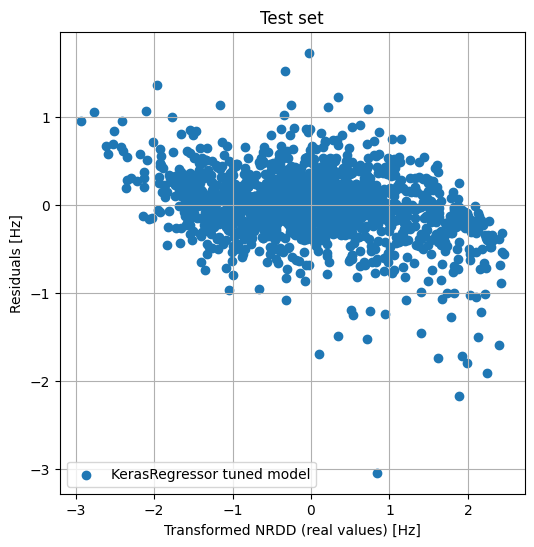

In [12]:
w_pred_tuned_regr = pd.DataFrame(pipe_tuned_regr.predict(X_test), index=idx_test)
residuals_regr = w_pred_tuned_regr-w_test

fig = plt.figure(figsize=(6, 6))
plt.scatter(w_test, residuals_regr, label='KerasRegressor tuned model')
plt.xlabel('Transformed NRDD (real values) [Hz]')
plt.ylabel('Residuals [Hz]')
plt.title('Test set')
plt.grid(True)
plt.legend()
plt.show()

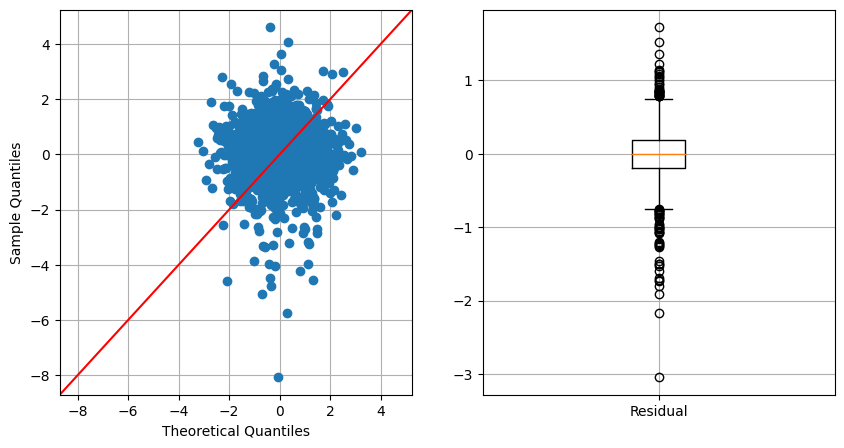

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sm.qqplot(residuals_regr, fit=True, line='45', ax=ax)
plt.grid(True)
plt.plot

ax = fig.add_subplot(1, 2, 2)
plt.boxplot(residuals_regr)
plt.xticks([1], ['Residual'], rotation=0)
plt.xticks([1], ['Residual'], rotation=0)
plt.grid(True)

plt.show()

* The residuals do not follow a normal law
* but are centered around 0

For a better understanding the evaluation will be resumed with the real values (y) of the NRDD, instead of its transformation (w)

In [15]:
# Transform the NRDD predictions and true values back
y_pred_tuned_regr = pd.DataFrame(transf.inverse_transform(w_pred_tuned_regr), index=idx_test)
y_test = pd.DataFrame(transf.inverse_transform(w_test), index=idx_test)

X does not have valid feature names, but PowerTransformer was fitted with feature names
X does not have valid feature names, but PowerTransformer was fitted with feature names


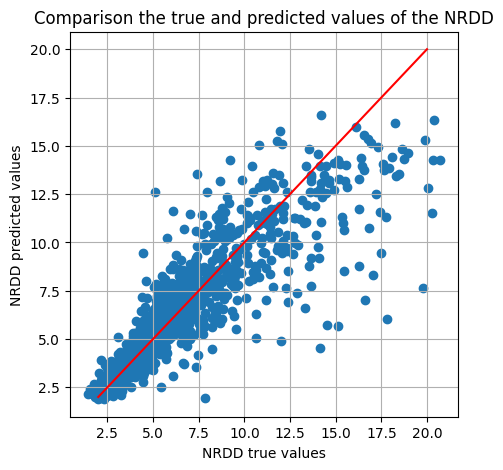

In [16]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_tuned_regr)
plt.plot([2, 20], [2, 20], color='r')
plt.xlabel('NRDD true values')
plt.ylabel('NRDD predicted values')
plt.title('Comparison the true and predicted values of the NRDD')
plt.grid(True)
plt.plot
plt.show()

## Best and worst predictions

We notice that the spreading is growing with higher values of the NRDD (very poor uniformities). The displacements and the corresponding NRDD criterions will be calculated for the design points with the best and the worst predictions

In [17]:
residuals_regr_abs = np.abs(residuals_regr)
# Determination of the indexes
idx_res_max = residuals_regr_abs[0].idxmax()
idx_res_min = residuals_regr_abs[0].idxmin()

In [18]:
def get_coordinates_displacement(dp):
    """"
    Get node coordinates and displacements for a particular design point"
    """
    
    # Get nodes and displacements of the mode
    nodes = df_nodes[df_nodes['dp_no'] == dp]
    defs = df_defs[df_defs['dp_no'] == dp]

     # Merge node coordinates and displacements
    uy_nodes = pd.merge(nodes, defs, how='inner', on='node_no', suffixes=['', '_1'])   

    return uy_nodes

def plot_2d_norm_disp(dp, mode_no, set_zlim=False):
    """
    Visualization of the displacement of the output square [-1:1] as heatmap only
    # Arguments
    dp:         design point
    mode_no:    mode number
    set_zlim:   set min z to 0
    """

    # Get frequency of the mode
    frequency = df_modes.loc[(df_modes['dp_no'] == dp) & (df_modes['mode_no'] == mode_no), 'freq'].item()

    # Column name of the displacement
    col_disp = 'mode' + str(mode_no)

    # Get nodes and displacements of the mode
    uy_nodes = get_coordinates_displacement(dp)
    px = uy_nodes['x_coord_n']
    pz = uy_nodes['z_coord_n']
    disp = np.array(uy_nodes[col_disp])
    # If the displacement is negative at the first node, reverse the displacement vector (makes sense particularly for the longitudinal mode)
    if disp[0] < 0:
        disp = -disp

    # two-dimensional interpolation with scipy.interpolate.griddata
    x = np.linspace(px.min(), px.max(), 20)
    z = np.linspace(pz.min(), pz.max(), 20)
    X, Z = np.meshgrid(x, z)
    Disp_near = griddata((px, pz), disp, (X, Z), method='nearest')
    Disp_cub = griddata((px, pz), disp, (X, Z), method='cubic')
    title = format('Design point %i\n Mode #%i (%0.0f Hz)' % (dp, mode_no, frequency))

    # 2d plot
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.axis('equal')
    cs = ax1.contourf(X, Z, Disp_cub, levels=15, cmap='jet')
    ax1.set_title(title)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Z')

    # 3d plot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.axis('equal')
    ax2.plot_surface(X, Z, Disp_cub, cmap='jet', shade=True, rstride=1, cstride=1)
    ax2.set_title(title)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Z')
    ax2.set_xlim([-1.1, 1.1])
    ax2.set_ylim([-1.1, 1.1])
    if set_zlim:
        ax2.set_zlim([0, max(disp)])
    else:
        ax2.set_zlim([min(disp), max(disp)])
    plt.colorbar(cs)
    plt.show()

    return X, Z, Disp_near

Design point with the smallest residual (best prediction)

In [20]:
dp_no_res_min = df_params.loc[idx_res_min, 'dp_no']
mode_no_res_min = df_params.loc[idx_res_min, 'mode_no_long']

print('Design point with the smallest residual:', dp_no_res_min)
print('Number of the long. mode:', mode_no_res_min)

print('Predicted NRDD:', y_pred_tuned_regr.loc[idx_res_min].item())
print('Real NRDD:', y_test.loc[idx_res_min].item())

Design point with the smallest residual: 11179
Number of the long. mode: 54
Predicted NRDD: 2.837722063064575
Real NRDD: 2.83846217804912


In [22]:
df_params.loc[idx_res_min, ['freq_long', 'freq_delta_below', 'freq_delta_above']]

freq_long           19421.334
freq_delta_below      -33.006
freq_delta_above       195.37
Name: 7169, dtype: object

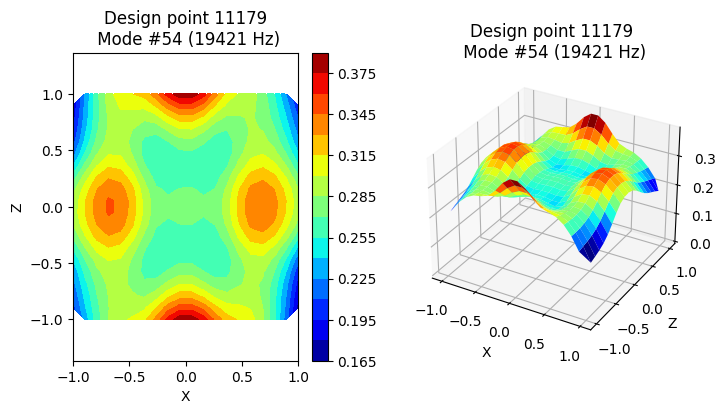

In [21]:
plot_2d_norm_disp(dp_no_res_min, mode_no_res_min, True);

Design point with the largest residual (worst prediction)

In [23]:
dp_no_res_max = df_params.loc[idx_res_max, 'dp_no']
mode_no_res_max = df_params.loc[idx_res_max, 'mode_no_long']

print('Design point with the largest residual:', dp_no_res_max)
print('Number of the long. mode:', mode_no_res_max)

print('Predicted NRDD:', y_pred_tuned_regr.loc[idx_res_max].item())
print('Real NRDD:', y_test.loc[idx_res_max].item())

Design point with the largest residual: 5961
Number of the long. mode: 66
Predicted NRDD: 1.959148645401001
Real NRDD: 7.846586722192887


In [24]:
df_params.loc[idx_res_max, ['freq_long', 'freq_delta_below', 'freq_delta_above']]

freq_long           19363.449
freq_delta_below     -486.686
freq_delta_above        1.813
Name: 3956, dtype: object

It stands out that the DP 5961 has a very small value of the feature "freq_delta_above": it means that another mode has its frequency close to the longitudinal frequency (1.8 Hz!). This is a typical case of a modal interaction, causing a mixing of the mode shapes and this interaction is obvious when both mode shapes are plotted below. The longitudinal mode gets a portion of the displacements of its neighbour, resulting in a poor uniformity of the displacement.

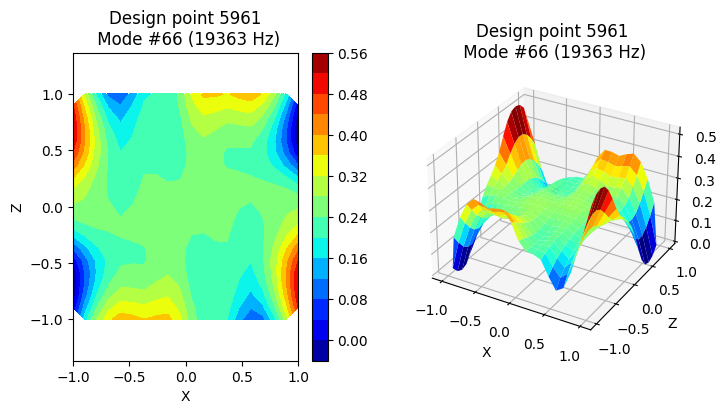

In [25]:
# Representation of the displacement of the longitudinal mode
plot_2d_norm_disp(dp_no_res_max, mode_no_res_max, True);

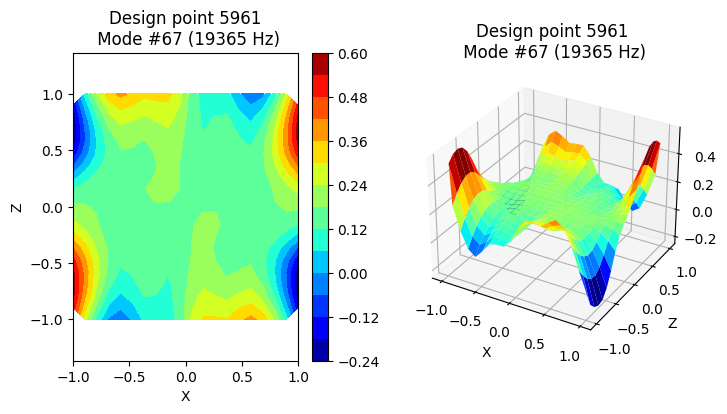

In [26]:
# Representation of the displacement of the next neighbour mode
plot_2d_norm_disp(dp_no_res_max, mode_no_res_max+1, False);

We introduce the new feature 'freq_delta_min' as the smallest distance ot the neighbour mode (minimum value between the above and below frequency deltas)

In [27]:
df_params['freq_delta_min'] = df_params.apply(lambda row: min([-row['freq_delta_below'], row['freq_delta_above']]), axis=1)

In [28]:
# Assign the new feature to the test dataset
freq_delta_min_test = df_params.loc[idx_test, 'freq_delta_min']

We want to know if the quality of the prediction depends on the vicinity of the other modes

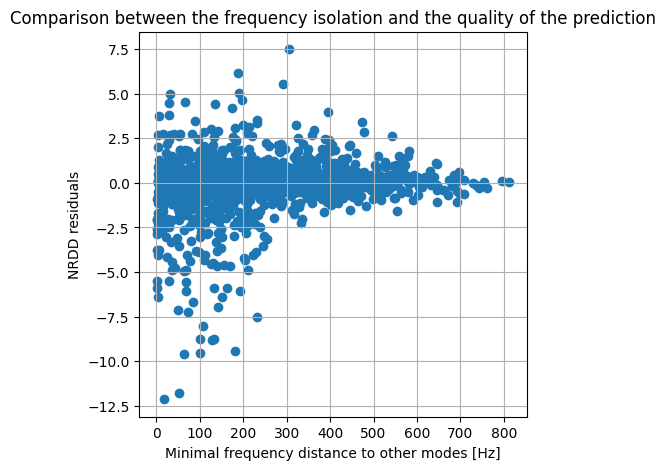

In [29]:
# The residuals are calculated between the real and predicted values of the NRDD (untransformed target variable)
y_residuals_regr = y_pred_tuned_regr-y_test

fig = plt.figure(figsize=(5, 5))
plt.scatter(freq_delta_min_test, y_residuals_regr)
plt.xlabel('Minimal frequency distance to other modes [Hz]')
plt.ylabel('NRDD residuals')
plt.title('Comparison between the frequency isolation and the quality of the prediction')
plt.grid(True)
plt.plot
plt.show()

The residuals are getting smaller when the longitudinal frequency is isolated from other modes. This statement is favorable for the design strategy of the sonotrode: the longitudinal mode has to be as much as possible isolated from other modes, which is part of the objectives.
Under 250 Hz of frequency delta the prediction can be strongly disturbed by the modal interactions.

### Portion of data with a frequency isolation greater than 250 Hz

As for the modelling of the longitudinal frequency, we want to check how big the portion of data is, for which the frequency isolation is big enough.

In [32]:
print('If the threshold for the frequency isolation is set at 250 Hz, ', len(df_params.loc[df_params['freq_delta_min'] > 250])/len(df_params)*100, '% of the data will be kept for the model.')

If the threshold for the frequency isolation is set at 250 Hz,  35.20650813516896 % of the data will be kept for the model.


## SHAP analysis

In [33]:
X100 = shap.utils.sample(X, 100)

In [34]:
explainer = shap.Explainer(pipe_tuned_regr.predict, X100)
shap_values = explainer(X100)

PermutationExplainer explainer: 101it [01:23,  1.12it/s]                         


Low SHAP values mean that the geometrical parameter improve the uniformity of the output displacement with an important impact

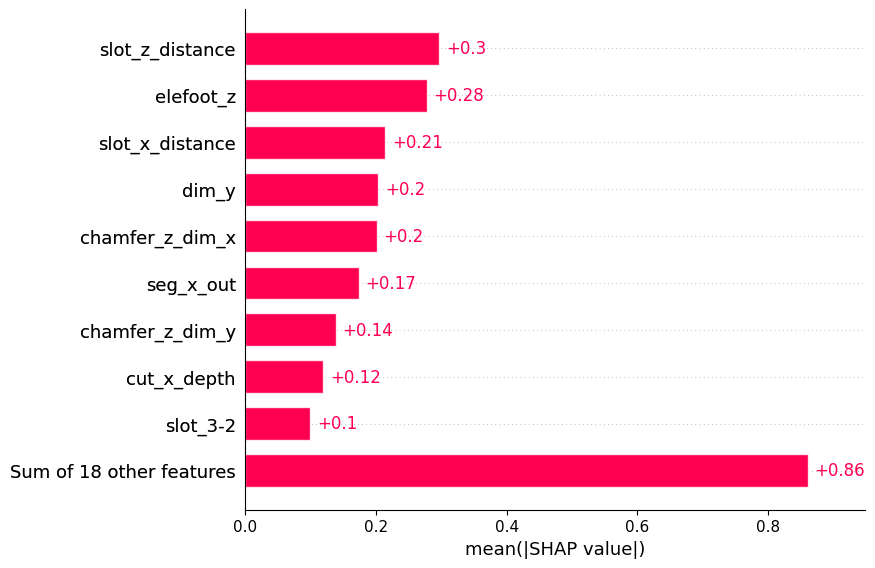

In [35]:
plt.figure(figsize=(4, 4))
shap.plots.bar(shap_values)

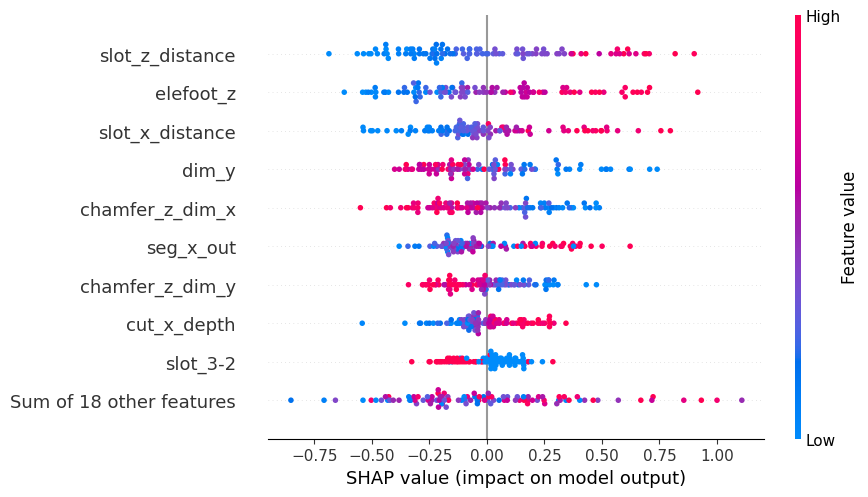

In [36]:
plt.figure(figsize=(4, 4))
shap.plots.beeswarm(shap_values)

* Elefoot in Z direction useless (lowest values give the best uniformity)
* Slot class 3-2 is the best slot distribution for this design: it leads to the best uniformity when active (high value = 1)
